# Turial : Conditional Neural Processes - 1D GP Data

Last Update : 11 June 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/homes/yd292/thesis/Semi-Supervised-Neural-Processes


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See the docstrings of `GPDataset` for more details. 

**Details**
- 1 D inputs (x) and outputs (y)
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)), with hyperparameters from [sklearn examples](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py): 
    - Squared Exponential
    - Matern
    - Exp-Sine-Squared (periodic)
    - Dot-Product (non-stationary and invariant to rotation around origin). 
- Points are sampled between (-5, 5) but scaled in (-1,1) as for inputs to the model (worked just as well without rescaling but slighlty easier to code for more advance things).
- At every epoch we precompute all the sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled functions for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the datset for one epoch.

**Extensions**

- Adding a dataset from a new kernel is straightforward by definining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).
- TO-DO : add a function to sample extrapolation points

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
NUM_POINTS = 128
NUM_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(num_samples=NUM_SAMPLES, num_points=NUM_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

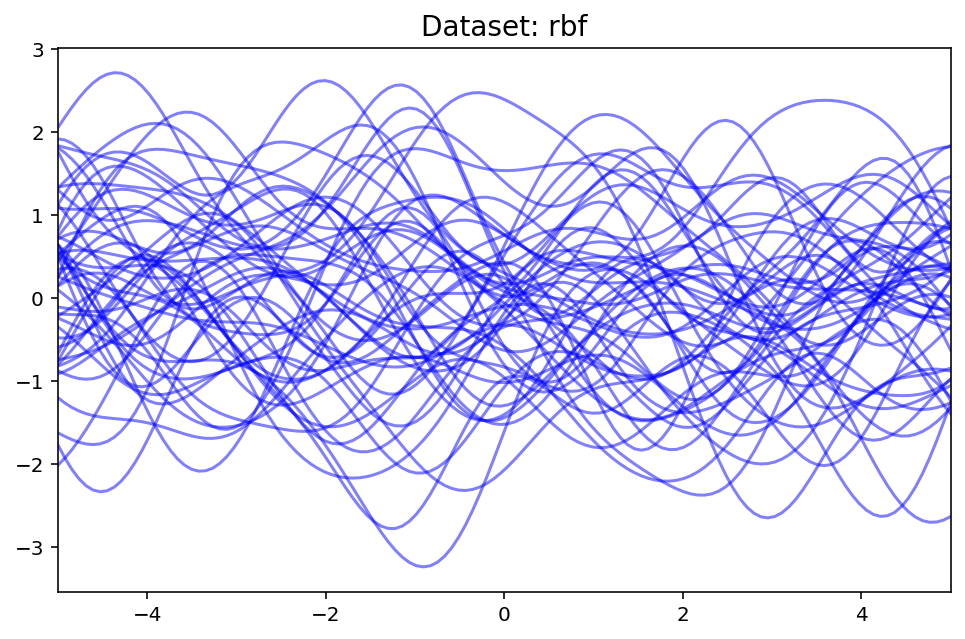

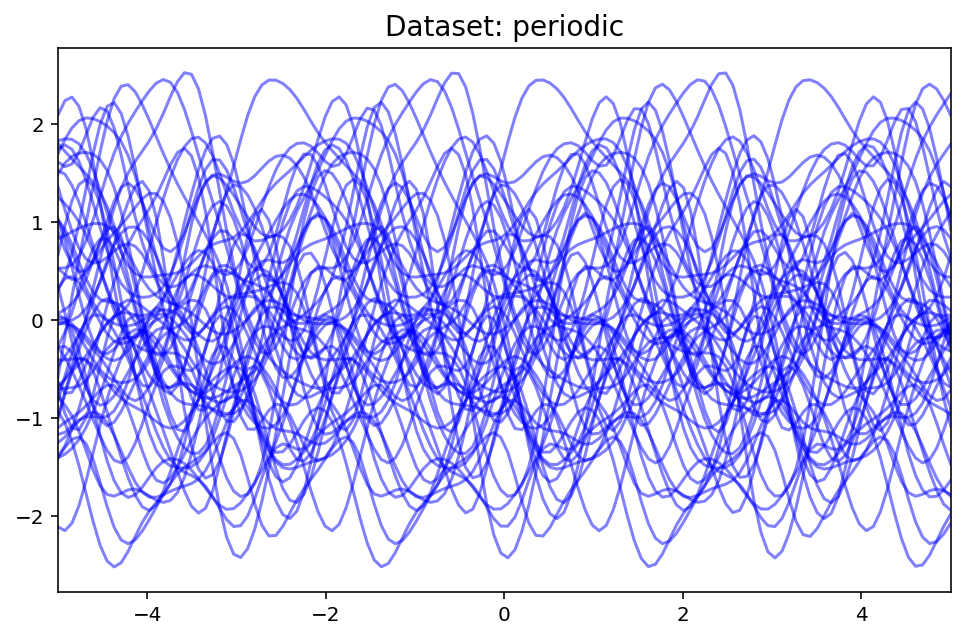

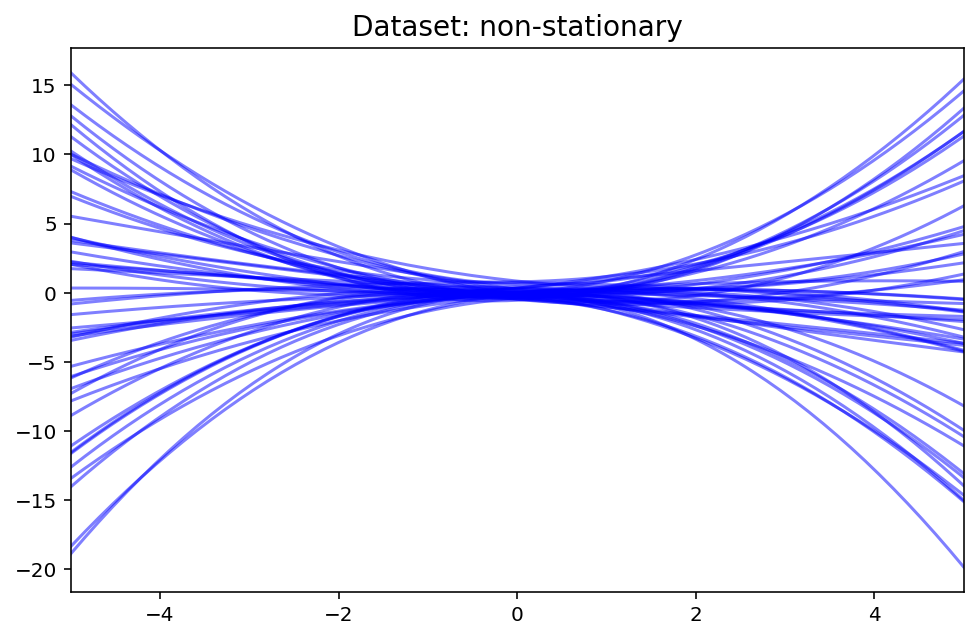

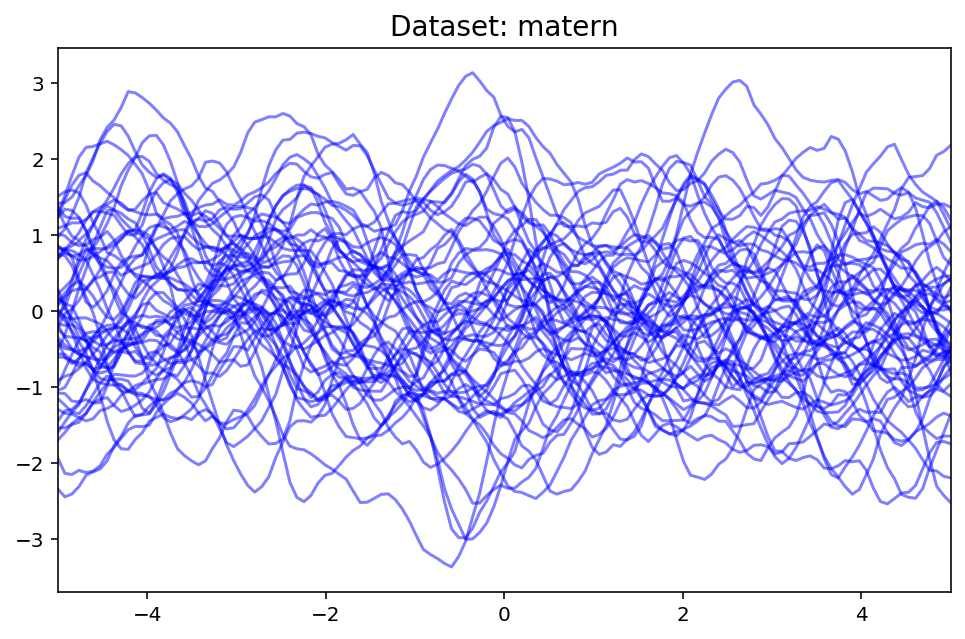

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. See the docstrings of `NeuralProcess` for more details. 


Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension of hidden representation.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `add_flat_input(MLP)` : learn representation with MLP (`add_flat_input` changes the constructor generaltity / compatibility)
    - `SelfAttentionBlock` : self attention mechanisms (as [Attentive Neural Process][anp]). For more parameters (attention type, number of layers ...) refer to its docstrings.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `add_flat_input(MLP)` : predict with MLP.
    - `SelfAttentionBlock` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process][anp], but in [image transformer][im transf]). 
- `aggregator` : Agregreator function which maps $\{r_i\} \to r$. To use a cross attention aggregation, use `AttentiveNeuralProcess` instead of `NeuralProcess`.
- `get_cntxt_trgt` :  Function that split the input into context and target points. Note: context points should be a subset of target ones.


**Additional Parameters : (Attentive) Neural Process**

- `encoded_path` : Which path(s) to use:
    - `"deterministic"` uses a [Conditional Neural Process][cnp] (no latents), where the decoder gets a deterministic representation as input (function of the context). 
    - `"latent"` uses a [Neural Process][np], where the decoder gets a sample latent representation as input (function of the target during training and context during test).
    - If `"both"` concatenates both representations as described in [Attentive Neural Process][anp].
- `LatentEncoder` : Encoder which maps $r \to [\mu_z; f(\sigma_z)]$. Only used if `encoded_path` in `["latent", "both"]`.

To use cross-attention instead of aggregation (i.e. [Attentive Neural Process][anp]) replace `NeuralProcess` with `AttentiveNeuralProcess`. Many different attention mechanisms are available (image transformer, multihead, dot head, manhattan ...), see its docstrings for more details. 
    

**Extensions**

- For Neural Process, see the [Tutorial - Neural Process][np tuto] notebook.
- For Attentive Neural Process, see the [Tutorial - Attentive Neural Process][anp tuto] notebook.
- Bayesian Hyperparameter Optimization is easy to run as the library is a wrapper around sklearn. To do so use `BayesSearchCV` from `skopt` which is in *requirements.txt* ([example](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html))

[np]: https://arxiv.org/abs/1807.01622
[cnp]: https://arxiv.org/pdf/1807.01613.pdf
[anp]: https://arxiv.org/abs/1901.05761
[im transf]: https://arxiv.org/abs/1802.05751
[np tuto]: Tutorial%20-%20Neural%20Process.ipynb
[anp tuto]: Tutorial%20-%20Attentive%20Neural%20Process.ipynb

In [8]:
from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, add_flat_input, DeepMLP
from skssl.transformers.neuralproc.datasplit import context_target_split

In [9]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, NUM_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [10]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # no sinusoidal encodings
                         XYEncoder=add_flat_input(DeepMLP),  # no self attention encoder (3 hidden layer MLP)
                         Decoder=add_flat_input(DeepMLP), # no self attention decoder (3 hidden layer MLP)
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         encoded_path="deterministic") # use CNP

In [11]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [12]:
from utils.helpers import count_parameters

In [13]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 136642


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

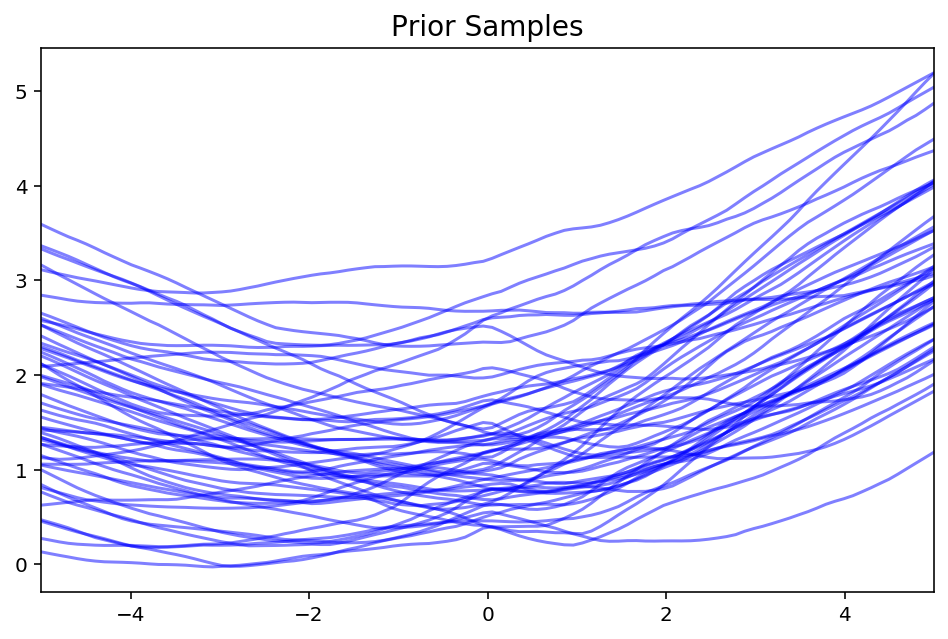

In [14]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, R_DIM, min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

In [15]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

In [16]:
N_EPOCHS = 30
# small batch size good to have different sizes of context / target
# but too smal becomes very slow (they use 16)
BATCH_SIZE = 64

In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 but don't want to train too long and we use larger batch
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      120.6754     +  22.5246


      2       77.3380     +  24.1560


      3       51.6757     +  24.6442


# Trained Prior

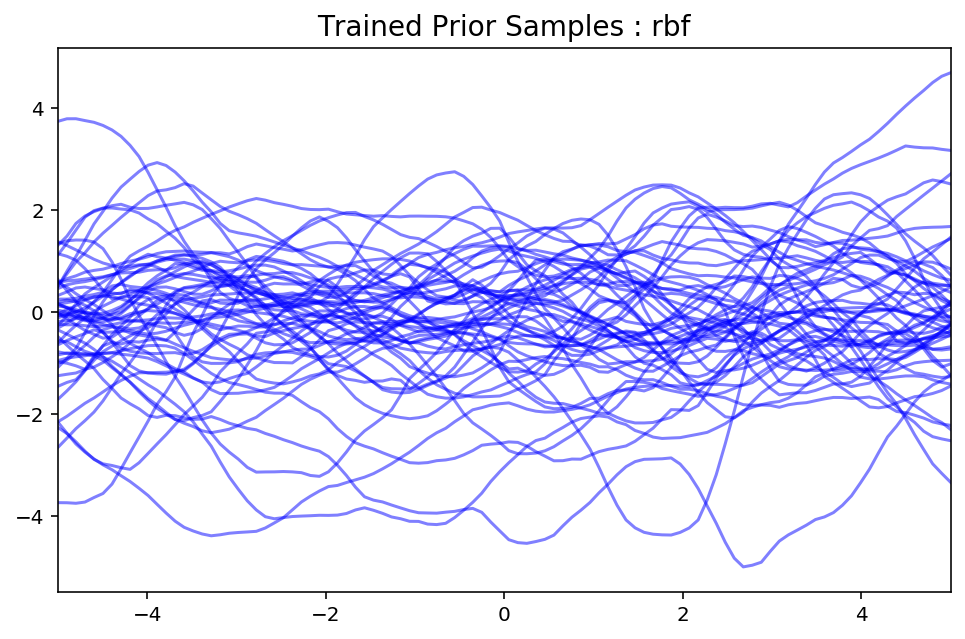

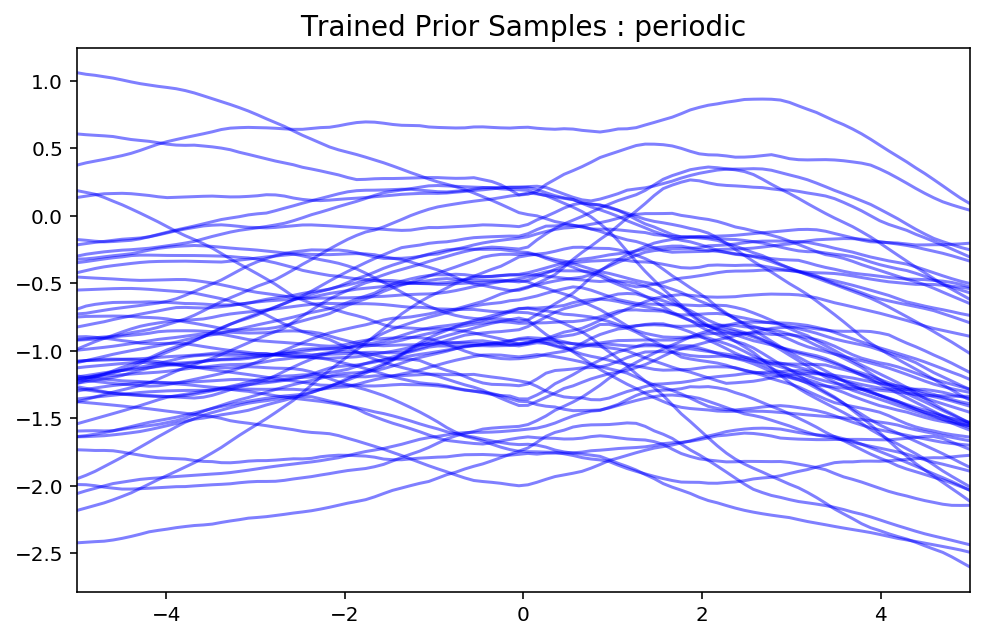

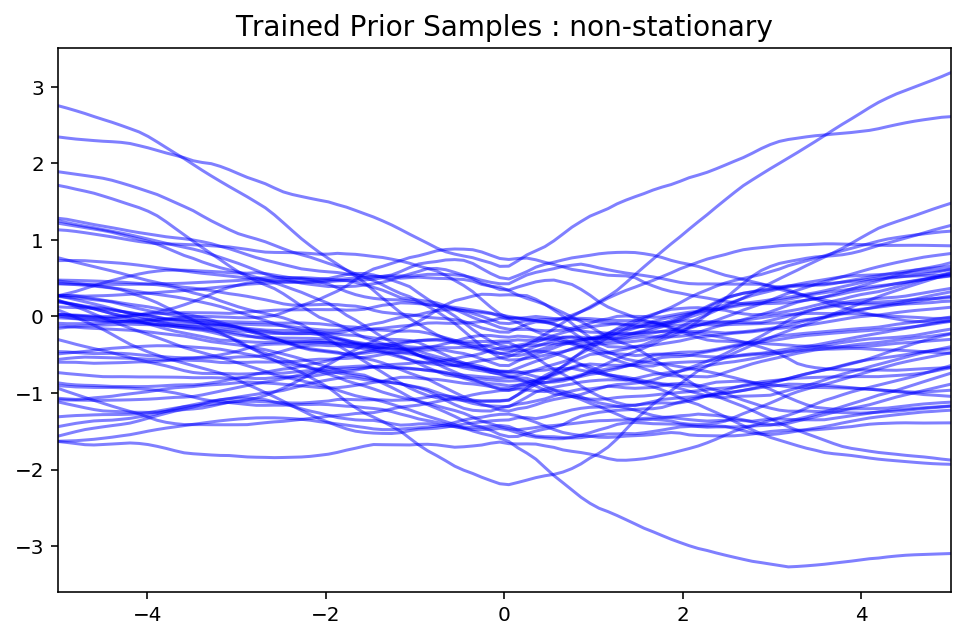

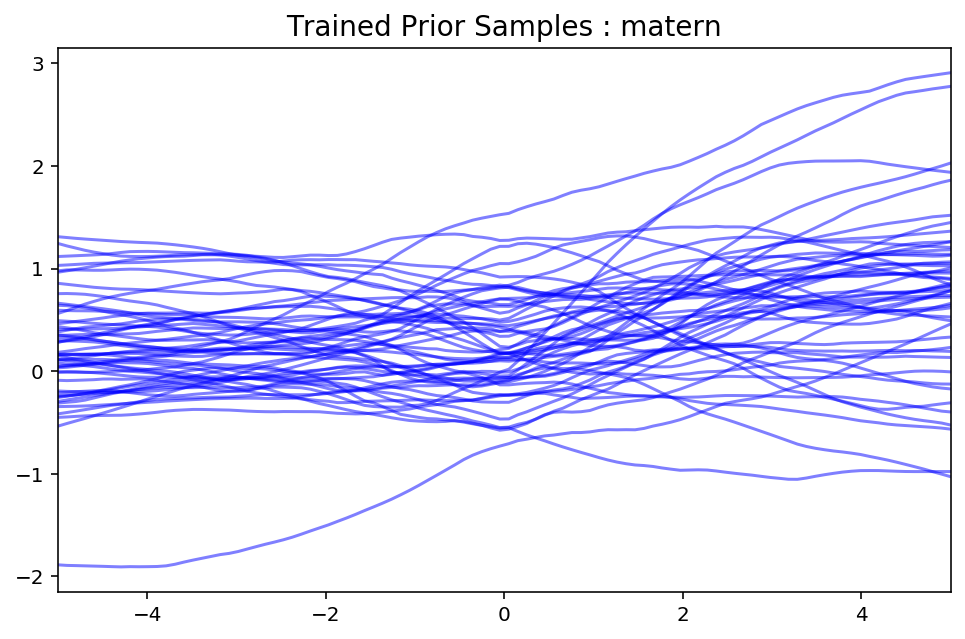

In [37]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, R_DIM, title="Trained Prior Samples : {}".format(k), min_max=dataset.min_max)

# Posterior

std: 0.36918113
std: 1.0707246
std: 4.209601
std: 0.8845071


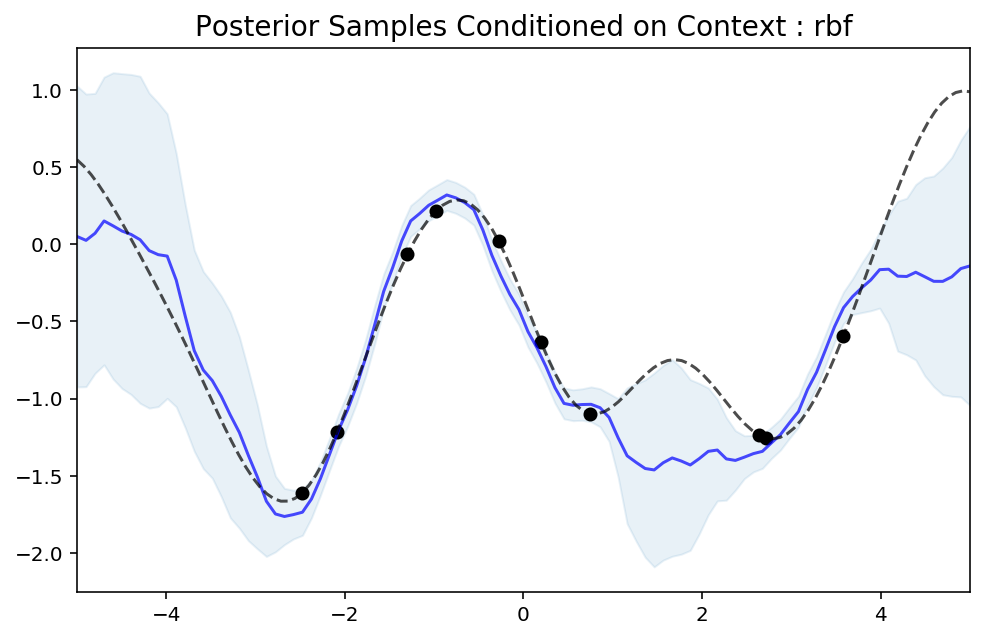

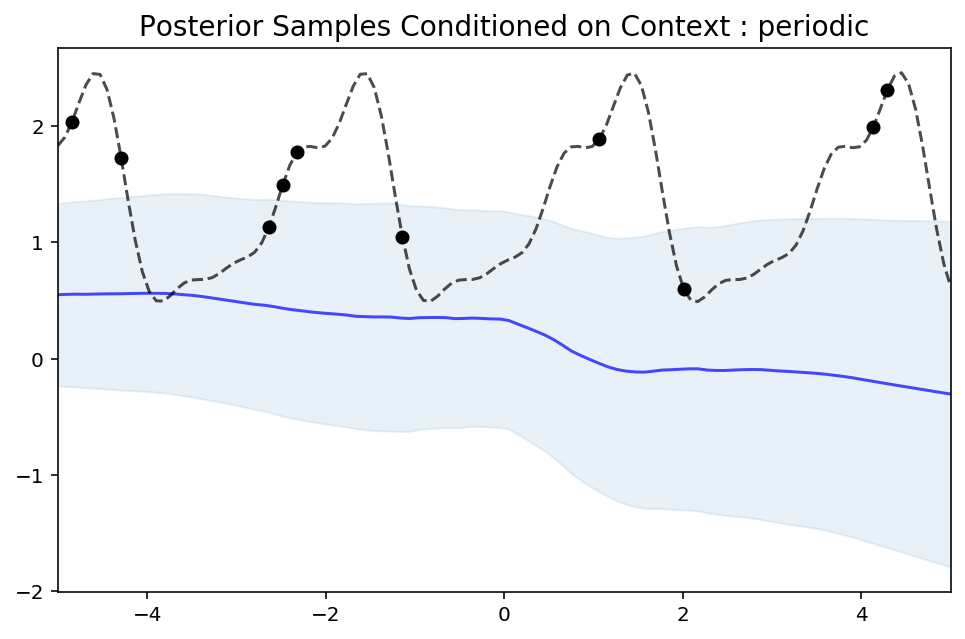

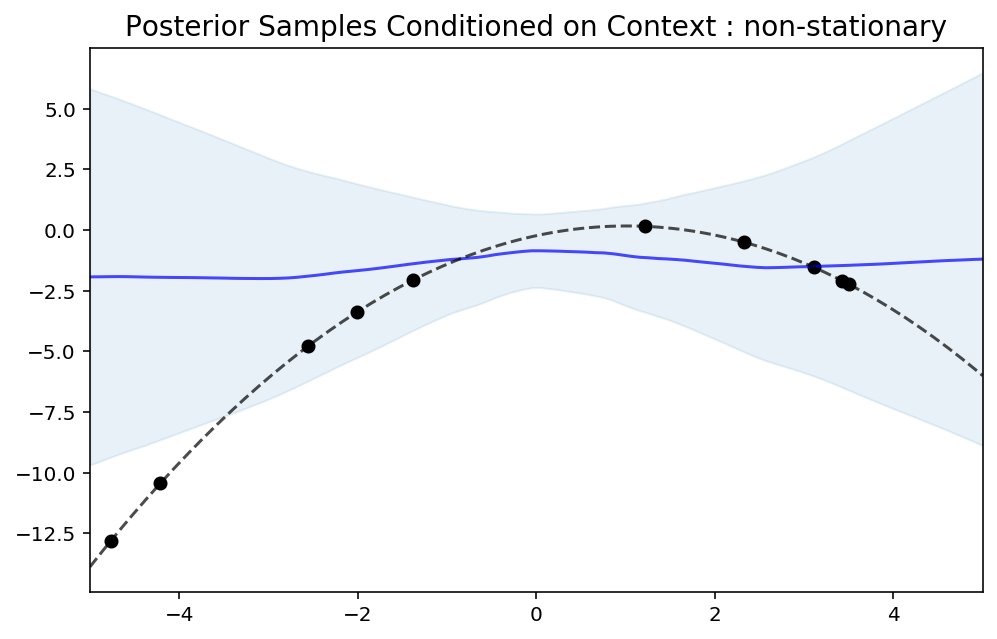

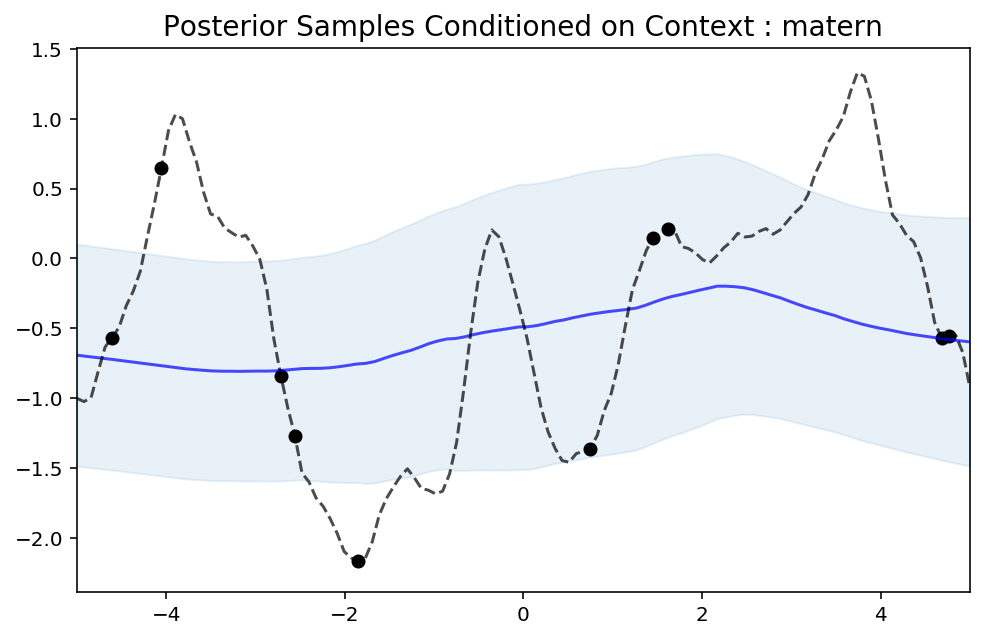

In [38]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

std: 1.466764
std: 0.82622147
std: 3.4578893
std: 1.1324519


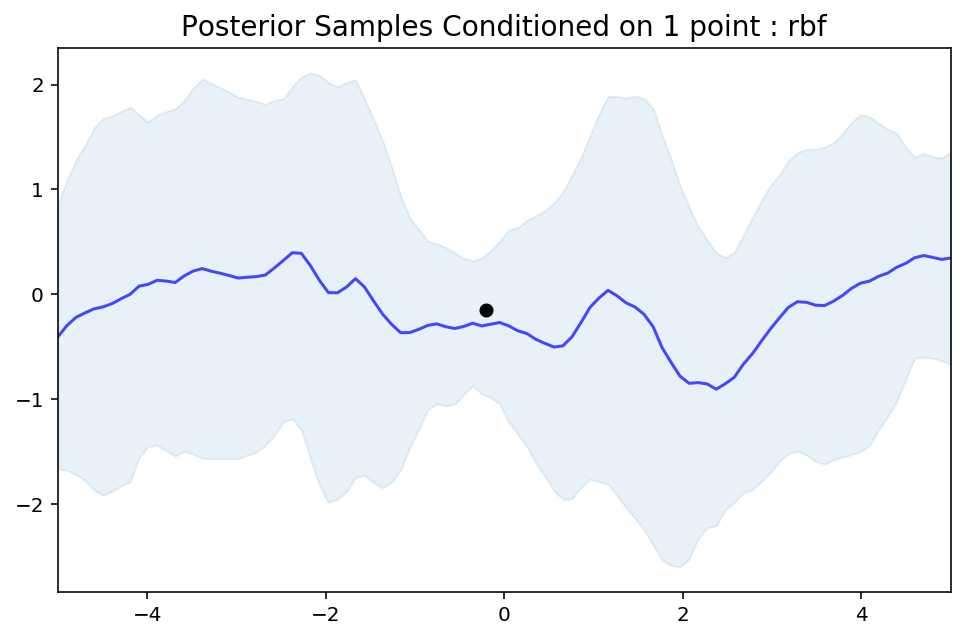

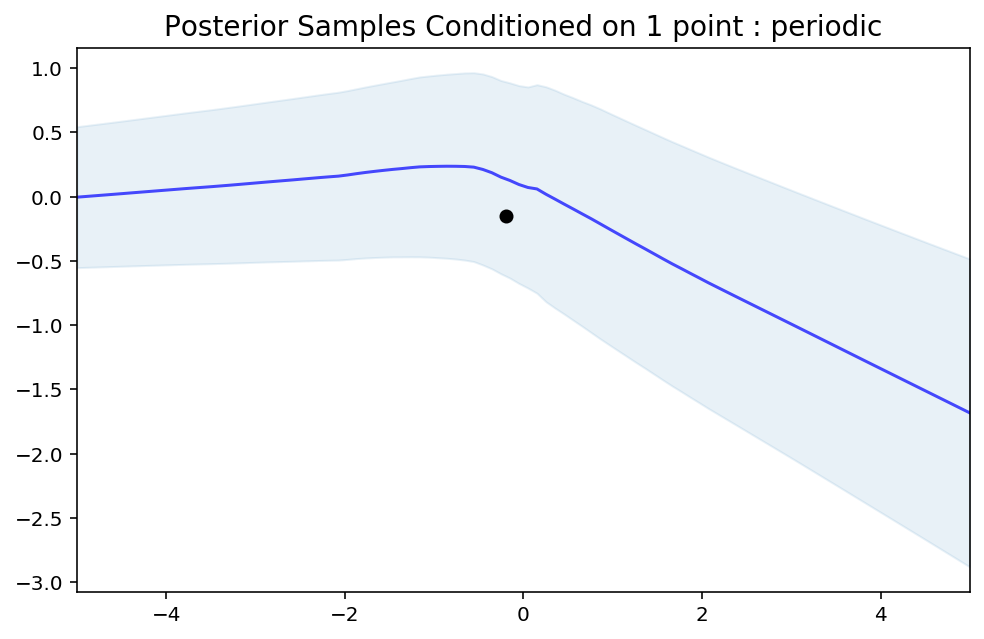

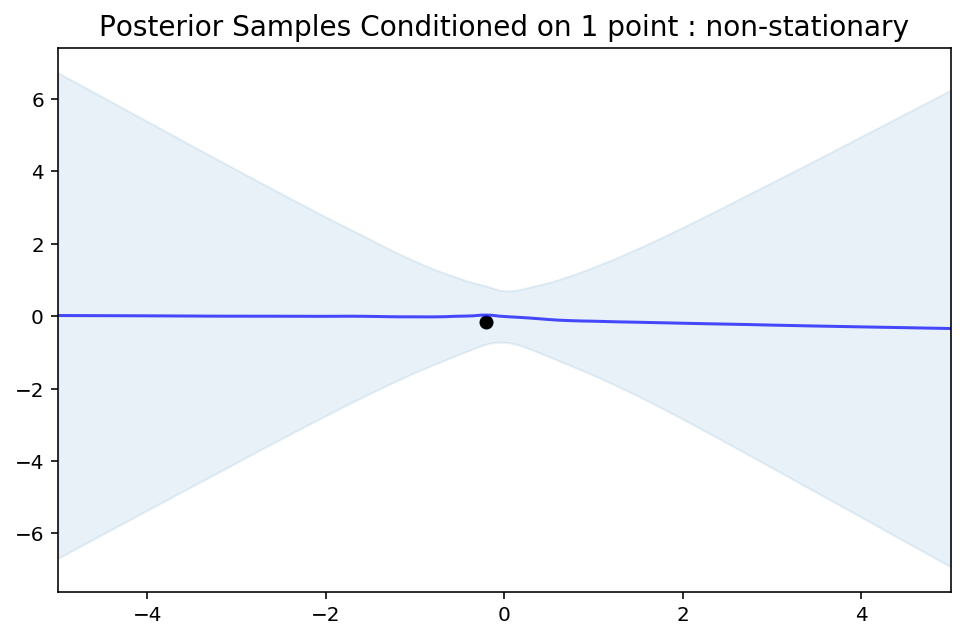

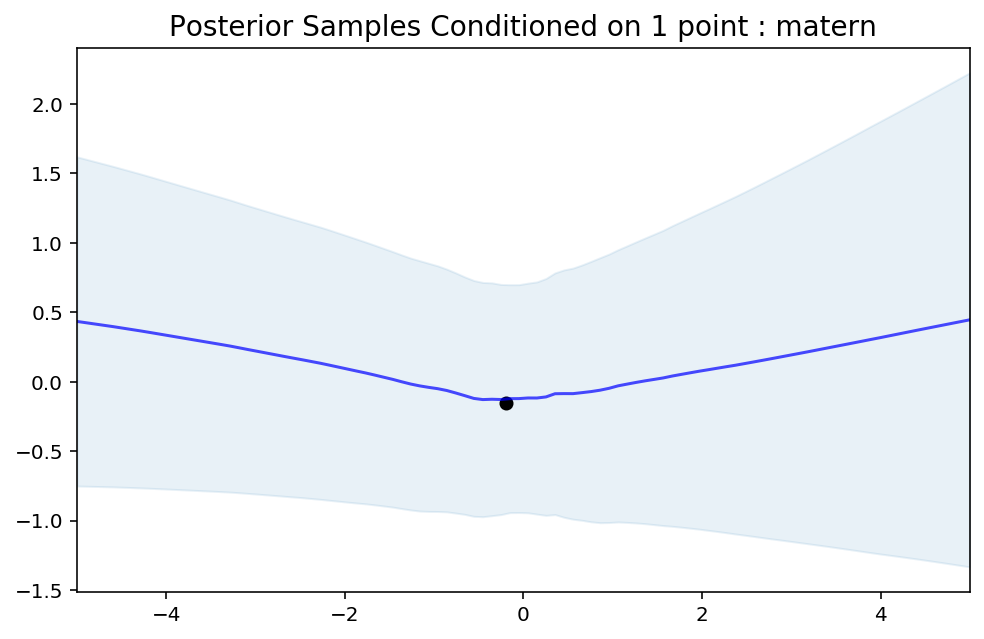

In [23]:
from skssl.utils.helpers import rescale_range 

for k,(neural_proc, dataset) in data_models.items():
    X = rescale_range(torch.tensor([[[-0.2]]]), dataset.min_max, (-1,1)) 
    Y = rescale_range(torch.tensor([[[-0.75]]]), dataset.min_max, (-1, 1))
    plot_posterior_samples(neural_proc, X, Y,  
                           is_plot_std=True, n_samples=1, min_max=dataset.min_max, 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 1.3642335
std: 0.8175948
std: 3.4193413
std: 1.1414244


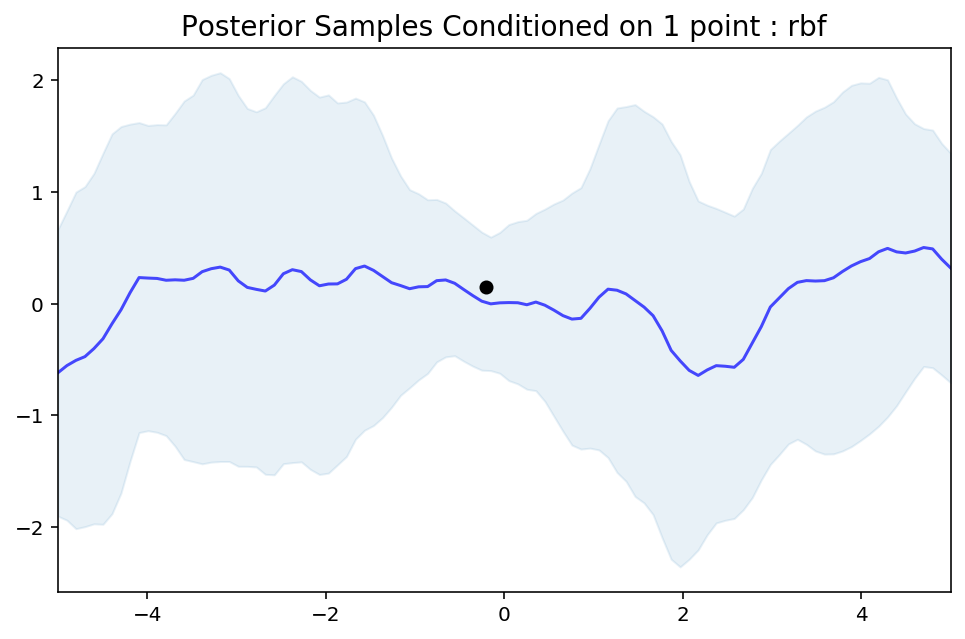

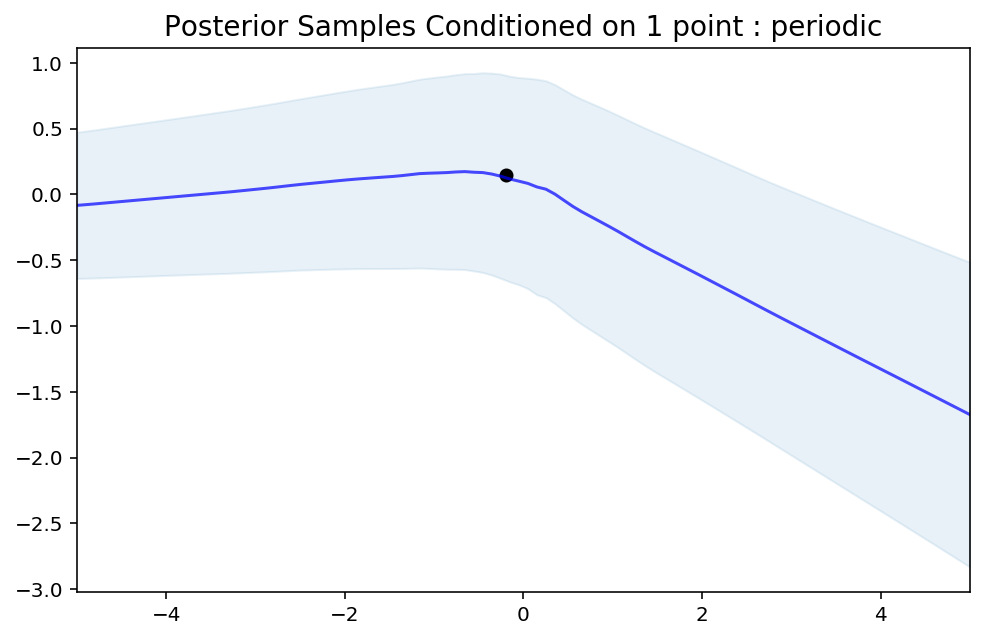

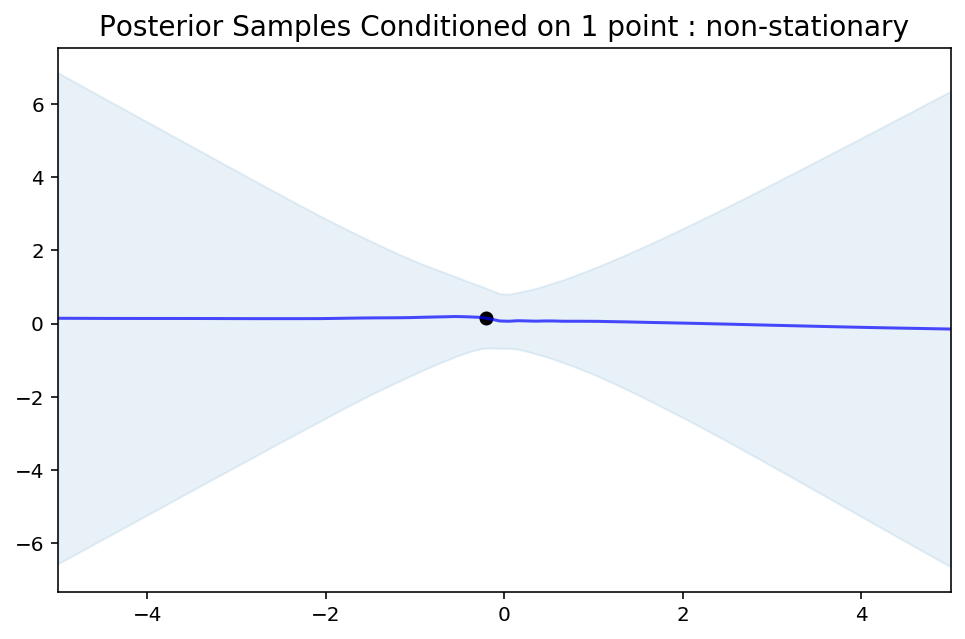

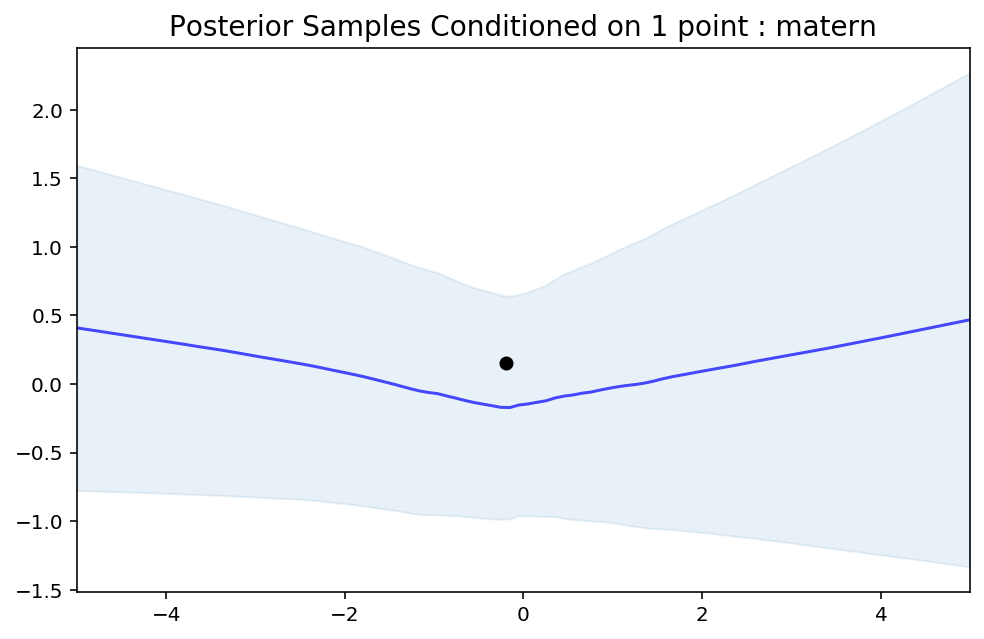

In [24]:
for k,(neural_proc, dataset) in data_models.items():
    X = rescale_range(torch.tensor([[[-0.2]]]), dataset.min_max, (-1,1)) 
    Y = rescale_range(torch.tensor([[[0.75]]]), dataset.min_max, (-1, 1))
    plot_posterior_samples(neural_proc, X, Y,  
                           is_plot_std=True,  n_samples=1, min_max=dataset.min_max, 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))